The basic code that klind of does wht we want it to do.

In [70]:
import cv2
import numpy as np
from pdf2image import convert_from_path
import matplotlib.pyplot as plt

class PDFProcessor:
    """Simple class to load PDF and detect features."""
    
    def __init__(self, file_path, dpi=300, poppler_path=r"poppler-25.07.0/Library/bin"):
        """
        Initialize with PDF file path.
        Args:
            file_path: Path to the PDF file.
            dpi: DPI for conversion.
        """
        self.file_path = file_path
        self.dpi = dpi
        self.poppler_path = poppler_path
        print(f"Loading PDF from: {file_path}")
        pil_image = convert_from_path(file_path, dpi=dpi, poppler_path=r"poppler-25.07.0/Library/bin")[1]  # First page only
        self.image_np = np.array(pil_image)
        self.gray = cv2.cvtColor(self.image_np, cv2.COLOR_BGR2GRAY) if len(self.image_np.shape) == 3 else self.image_np
        _, self.thresh = cv2.threshold(self.gray, 240, 255, cv2.THRESH_BINARY_INV)

    def _remove_duplicates(self, rectangles, threshold=10):
        """Remove duplicate rectangles based on position threshold."""
        if not rectangles:
            return rectangles
        unique = []
        for curr in rectangles:
            x1, y1, w1, h1 = curr
            if not any(abs(x1 - x2) <= threshold and abs(y1 - y2) <= threshold for x2, y2, w2, h2 in unique):
                unique.append(curr)
        return unique

    def detect_checkboxes(self, target_area=1000, tolerance=400, text_pixel_threshold=0.20):
        """Detect unfilled checkboxes."""
        contours, _ = cv2.findContours(self.thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        rects = []
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if (target_area - tolerance) <= area <= (target_area + tolerance):
                x, y, w, h = cv2.boundingRect(cnt)
                roi = self.thresh[y:y + h, x:x + w]
                non_zero_ratio = cv2.countNonZero(roi) / (w * h)
                if non_zero_ratio < text_pixel_threshold:
                    rects.append((x, y, w, h))
        return self._remove_duplicates(rects)

    def detect_lines(self, checkboxes=None, thickness_thresh=3, y_proximity=50):
        """Detect lines, optionally filtered near checkboxes."""
        contours, _ = cv2.findContours(self.thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        lines = []
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            length = max(w, h)
            thickness = min(w, h)
            if length >= 1 and thickness <= thickness_thresh:
                lines.append((x, y, w, h))
        
        if checkboxes is None:
            return self._remove_duplicates(lines)
        
        filtered = []
        for line in lines:
            _, line_y, _, _ = line
            y_occurrences = sum(1 for _, cb_y, _, _ in checkboxes if abs(line_y - cb_y) <= y_proximity)
            if not (1 <= y_occurrences <= 4):
                filtered.append(line)
        return self._remove_duplicates(filtered)

    def detect_whitespaces(self, target_area=1000):
        """Detect whitespace boxes."""
        contours, _ = cv2.findContours(self.thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        boxes = []
        for cnt in contours:
            area = cv2.contourArea(cnt)
            x, y, w, h = cv2.boundingRect(cnt)
            length = max(w, h)
            thickness = min(w, h)
            if length > 50 and thickness > 40:
                check_height = 30
                check_y_start = max(0, y - check_height)
                check_y_end = y
                region_above = self.thresh[check_y_start:check_y_end, x:x + w]
                white_pixels = cv2.countNonZero(region_above)
                if 50 < white_pixels < 2000:
                    boxes.append((x, y, w, h))
        
        # IQR filtering on heights
        heights = [h for _, _, _, h in boxes]
        if heights:
            q1, q3 = np.percentile(heights, 25), np.percentile(heights, 75)
            iqr = q3 - q1
            lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
            boxes = [box for box in boxes if lower <= box[3] <= upper]
        
        return self._remove_duplicates(boxes)

    def draw_checkboxes(self, checkboxes):
        """Draw detected checkboxes."""
        result = self.image_np.copy()
        for x, y, w, h in checkboxes:
            cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
        return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    def draw_lines(self, lines, box_height=30, box_padding=5):
        """Draw info boxes above lines."""
        result = self.image_np.copy()
        for x, y, w, h in lines:
            x1 = max(x - box_padding, 0)
            x2 = min(x + w + box_padding, result.shape[1] - 1)
            y1 = max(y - box_height, 0)
            y2 = y
            cv2.rectangle(result, (x1, y1), (x2, y2), (0, 255, 0), 2)
        return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    def draw_whitespaces(self, boxes, shrink=10):
        """Draw shrunk boxes toward the bottom."""
        result = self.image_np.copy()
        for x, y, w, h in boxes:
            ignore_top = int(h * 0.50)
            new_x, new_y = x + shrink, y + ignore_top
            new_w, new_h = w - 2 * shrink, h - ignore_top - shrink
            if new_w > 0 and new_h > 0:
                cv2.rectangle(result, (new_x, new_y), (new_x + new_w, new_y + new_h), (0, 255, 0), 2)
        return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

In [71]:
processor = PDFProcessor("Forms/death.pdf")
processor

Loading PDF from: Forms/death.pdf


In [72]:
checkboxes = processor.detect_checkboxes()
lines = processor.detect_lines(checkboxes)  # Or without checkboxes: processor.detect_lines()
whitespaces = processor.detect_whitespaces()

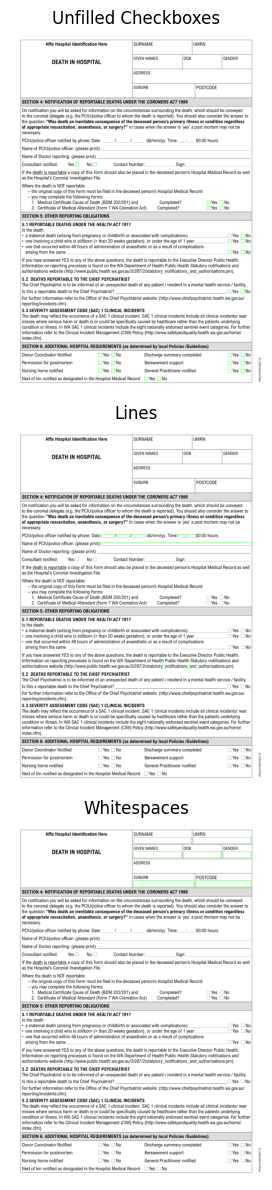

In [73]:
import matplotlib.pyplot as plt
img_checkboxes = processor.draw_checkboxes(checkboxes)
line_checkboxes = processor.draw_lines(lines)
whitespaces_checkboxes = processor.draw_whitespaces(whitespaces)
# Display three separate plots
plt.figure(figsize=(10, 12))

# Plot 1: Checkboxes
plt.subplot(3, 1, 1)  # 3 rows, 1 column, 1st subplot
plt.imshow(img_checkboxes)
plt.axis('off')
plt.title('Unfilled Checkboxes')

# Plot 2: Lines
plt.subplot(3, 1, 2)  # 3 rows, 1 column, 2nd subplot
plt.imshow(line_checkboxes)
plt.axis('off')
plt.title('Lines')

# Plot 3: Whitespaces
plt.subplot(3, 1, 3)  # 3 rows, 1 column, 3rd subplot
plt.imshow(whitespaces_checkboxes)
plt.axis('off')
plt.title('Whitespaces')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [62]:
#Advanced version of the code that is more generalizable to many PDFS: